In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

In [ ]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Correctly initialize the 'samples' list
        self.samples = []
        self.classes = {'NORMAL': 0, 'PNEUMONIA': 1}

        for class_name, label in self.classes.items():
            subfolder_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(subfolder_path):
                continue
            
            for f in os.listdir(subfolder_path):
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Append a tuple of (full_image_path, label)
                    full_path = os.path.join(subfolder_path, f)
                    self.samples.append((full_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # This part now works correctly as self.samples exists
        img_path, label = self.samples[idx]
        
        # Open image and convert to RGB to ensure consistency before transforms
        image = Image.open(img_path).convert("RGB") 
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

IMG_SIZE = 128
BATCH_SIZE = 8

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = ChestXrayDataset(root_dir=train_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Found {len(train_dataset)} images in the training set.")

Found 5216 images in the training set.


In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images(img_batch, n=16):
    # This function now correctly receives only the image tensor
    img_batch = (img_batch[:n] * 0.5 + 0.5).clamp(0, 1)
    
    grid = make_grid(img_batch, nrow=4)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

try:
    # Unpack the batch to separate images from labels
    # We use '_' for the labels because we don't need them here
    images_batch, _ = next(iter(train_dataloader))
    
    print("Displaying a sample of training images...")
    # Pass ONLY the images tensor to the show_images function
    show_images(images_batch)

except NameError:
    print("Error: 'train_dataloader' is not defined. Please run the data loading cell first.")
except StopIteration:
    print("Error: The DataLoader is empty. Please check your dataset path and file extensions in the data loading cell.")

Displaying a sample of training images...


In [ ]:
# Cell 4: GroupNorm Helper
def make_group_norm(num_channels, max_groups=8):
    g = min(max_groups, num_channels)
    while num_channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, num_channels)

In [ ]:
# Cell 5: Model Architecture (ResidualBlock and Deeper UNet)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.1, max_groups=8):
        super().__init__()
        self.norm1 = make_group_norm(in_channels, max_groups)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm2 = make_group_norm(out_channels, max_groups)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_proj = nn.Linear(time_emb_dim, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(self.act1(self.norm1(x)))
        h = h + self.time_proj(t_emb)[:, :, None, None]
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h + self.shortcut(x)

class UNet(nn.Module):
    def __init__(self, img_channels=1, base_channels=64, time_emb_dim=256):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        
        # Encoder
        self.enc1 = ResidualBlock(img_channels, base_channels, time_emb_dim) # 64
        self.enc2 = ResidualBlock(base_channels, base_channels*2, time_emb_dim) # 128
        self.enc3 = ResidualBlock(base_channels*2, base_channels*4, time_emb_dim) # 256
        self.enc4 = ResidualBlock(base_channels*4, base_channels*8, time_emb_dim) # 512
        
        self.bottleneck = ResidualBlock(base_channels*8, base_channels*8, time_emb_dim) # 512
        
        # Decoder
        self.dec4 = ResidualBlock(base_channels*16, base_channels*4, time_emb_dim) # 1024 -> 256
        self.dec3 = ResidualBlock(base_channels*8, base_channels*2, time_emb_dim)  # 512 -> 128
        self.dec2 = ResidualBlock(base_channels*4, base_channels, time_emb_dim)   # 256 -> 64
        self.dec1 = ResidualBlock(base_channels*2, base_channels, time_emb_dim)   # 128 -> 64
        
        self.final = nn.Conv2d(base_channels, img_channels, 1)
        
        self.down = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t = self.time_mlp(t.unsqueeze(-1).float())
        e1 = self.enc1(x, t)
        e2 = self.enc2(self.down(e1), t)
        e3 = self.enc3(self.down(e2), t)
        e4 = self.enc4(self.down(e3), t)
        b = self.bottleneck(self.down(e4), t)
        d4 = self.dec4(torch.cat([self.up(b), e4], dim=1), t)
        d3 = self.dec3(torch.cat([self.up(d4), e3], dim=1), t)
        d2 = self.dec2(torch.cat([self.up(d3), e2], dim=1), t)
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1), t)
        return self.final(d1)


In [ ]:
# Cell 6: DDPM Class
class DDPM(nn.Module):
    
    def __init__(self, model, n_steps=1000, beta_start=1e-4, beta_end=0.02, device="cuda", img_size=128):
        super().__init__()
        self.model = model
        self.n_steps = n_steps
        self.device = device
        self.img_size = img_size 
        
        self.beta = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    
    def forward_diffusion(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise
    
    def sample_timesteps(self, n):
        return torch.randint(0, self.n_steps, (n,), device=self.device)
    
    def sample(self, n):
        self.model.eval()
        x = torch.randn((n, 1, self.img_size, self.img_size), device=self.device)
        for t in tqdm(reversed(range(self.n_steps)), desc="Sampling"):
            z = torch.randn_like(x) if t > 0 else 0
            t_tensor = torch.tensor([t]*n, device=self.device)
            pred_noise = self.model(x, t_tensor)
            alpha = self.alpha[t]
            alpha_hat = self.alpha_hat[t]
            beta = self.beta[t]
            x = (1/torch.sqrt(alpha)) * (x - (1-alpha)/torch.sqrt(1-alpha_hat) * pred_noise) + torch.sqrt(beta) * z
        return x

/tmp/ipykernel_36/2460012760.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


🏁 Starting training from scratch.


  0%|          | 0/652 [00:00<?, ?it/s]/tmp/ipykernel_36/2460012760.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch [1/250]: 100%|██████████| 652/652 [02:18<00:00,  4.70it/s, loss=0.0355]


Epoch 1 | Avg Loss: 0.1743
   Generating sample images...


Sampling: 500it [00:05, 91.78it/s]


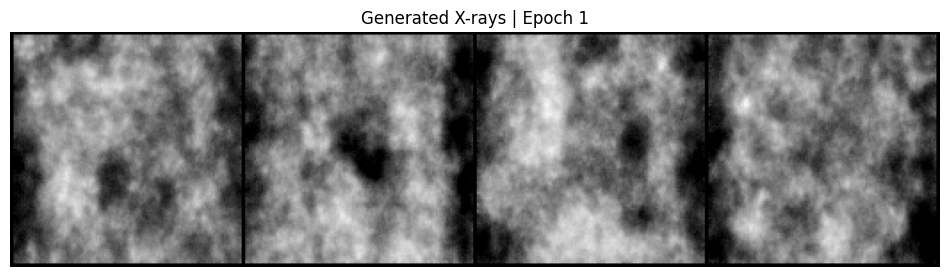

Epoch [2/250]: 100%|██████████| 652/652 [01:46<00:00,  6.13it/s, loss=0.0967] 


Epoch 2 | Avg Loss: 0.0449
   Generating sample images...


Sampling: 500it [00:05, 93.36it/s]


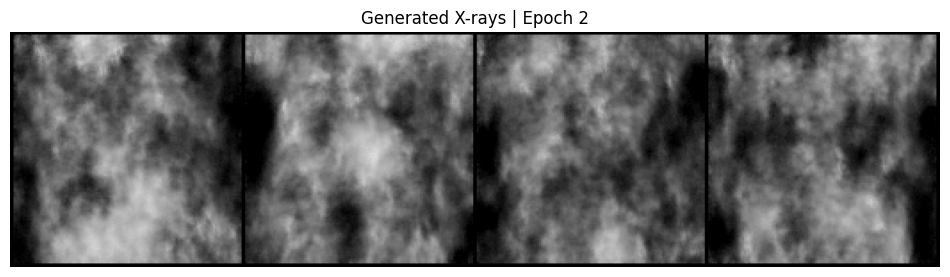

Epoch [3/250]: 100%|██████████| 652/652 [01:46<00:00,  6.13it/s, loss=0.014]  


Epoch 3 | Avg Loss: 0.0370
   Generating sample images...


Sampling: 500it [00:05, 93.27it/s]


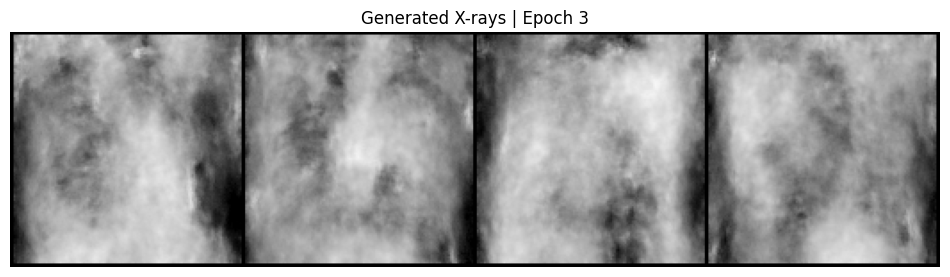

Epoch [4/250]: 100%|██████████| 652/652 [01:46<00:00,  6.14it/s, loss=0.0368] 


Epoch 4 | Avg Loss: 0.0338
   Generating sample images...


Sampling: 500it [00:05, 93.29it/s]


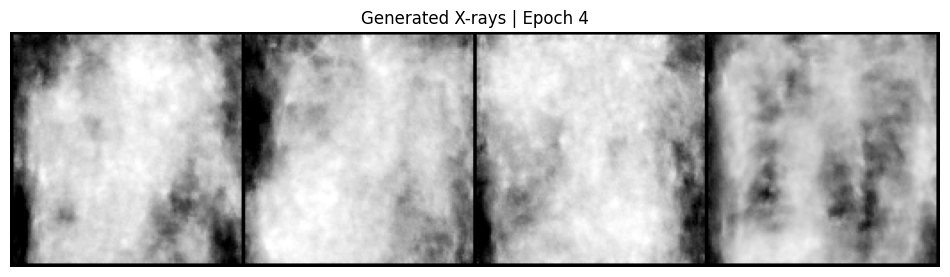

Epoch [5/250]: 100%|██████████| 652/652 [01:46<00:00,  6.14it/s, loss=0.0165] 


Epoch 5 | Avg Loss: 0.0331
   Generating sample images...


Sampling: 500it [00:05, 93.36it/s]


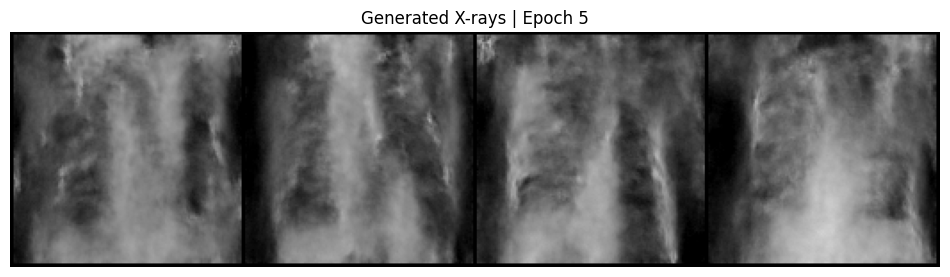

Epoch [6/250]: 100%|██████████| 652/652 [01:46<00:00,  6.14it/s, loss=0.0206] 


Epoch 6 | Avg Loss: 0.0317
   Generating sample images...


Sampling: 500it [00:05, 93.36it/s]


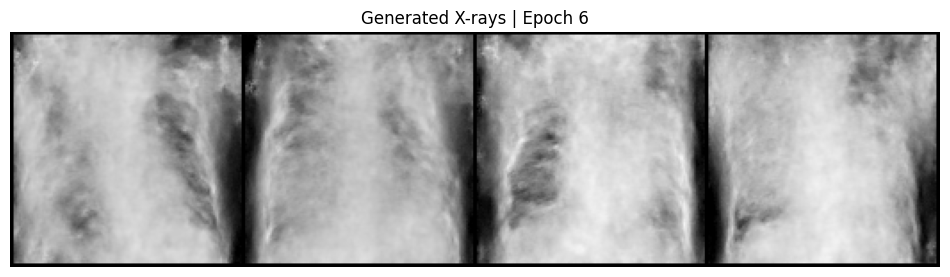

Epoch [7/250]: 100%|██████████| 652/652 [01:46<00:00,  6.12it/s, loss=0.0267] 


Epoch 7 | Avg Loss: 0.0293
   Generating sample images...


Sampling: 500it [00:05, 93.27it/s]


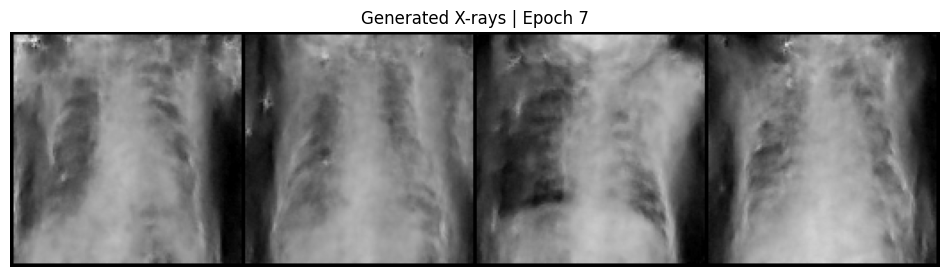

Epoch [8/250]: 100%|██████████| 652/652 [01:46<00:00,  6.12it/s, loss=0.0128] 


Epoch 8 | Avg Loss: 0.0287
   Generating sample images...


Sampling: 500it [00:05, 93.31it/s]


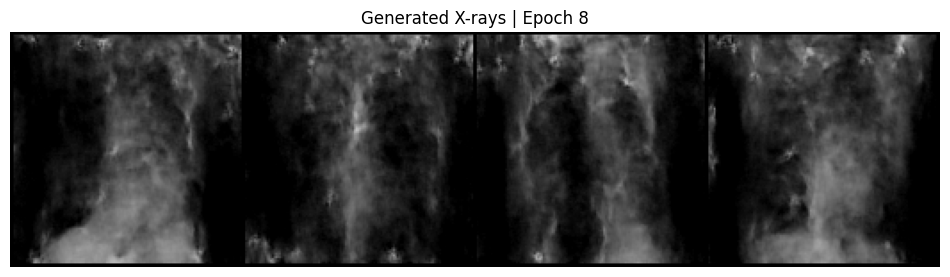

Epoch [9/250]: 100%|██████████| 652/652 [01:46<00:00,  6.13it/s, loss=0.00346]


Epoch 9 | Avg Loss: 0.0282
   Generating sample images...


Sampling: 500it [00:05, 93.34it/s]


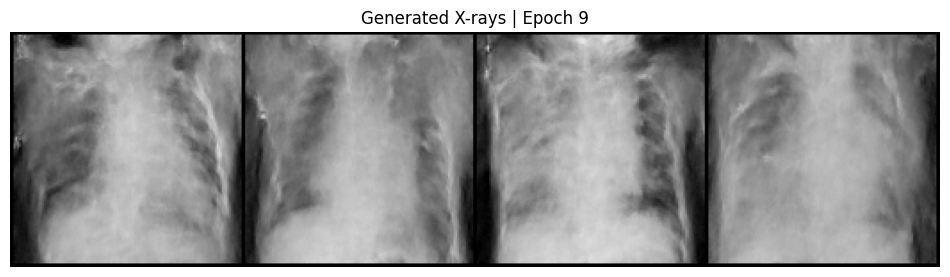

Epoch [10/250]: 100%|██████████| 652/652 [01:46<00:00,  6.13it/s, loss=0.0366] 


Epoch 10 | Avg Loss: 0.0293
   Generating sample images...


Sampling: 500it [00:05, 93.36it/s]


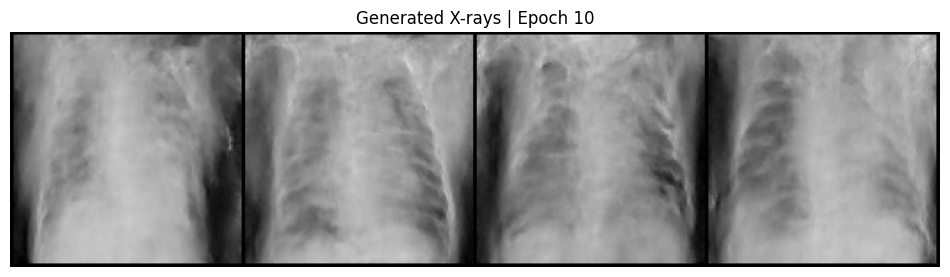

Epoch [11/250]: 100%|██████████| 652/652 [01:47<00:00,  6.07it/s, loss=0.0186] 


Epoch 11 | Avg Loss: 0.0275
   Generating sample images...


Sampling: 500it [00:05, 93.23it/s]


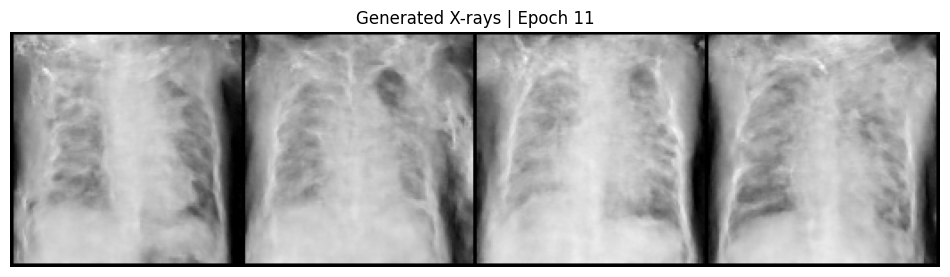

Epoch [12/250]: 100%|██████████| 652/652 [01:47<00:00,  6.09it/s, loss=0.0226] 


Epoch 12 | Avg Loss: 0.0267
   Generating sample images...


Sampling: 500it [00:05, 93.30it/s]


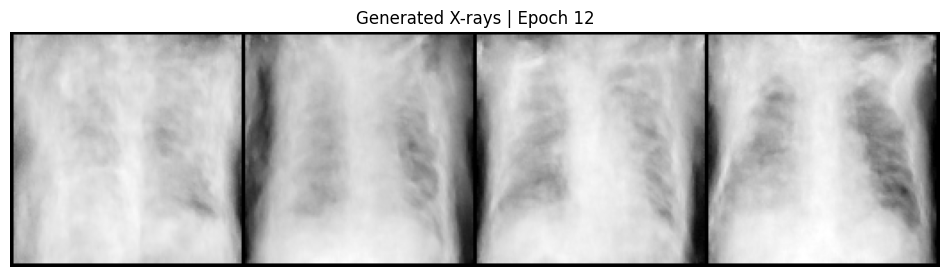

Epoch [13/250]: 100%|██████████| 652/652 [01:46<00:00,  6.14it/s, loss=0.0177] 


Epoch 13 | Avg Loss: 0.0286
   Generating sample images...


Sampling: 500it [00:05, 93.32it/s]


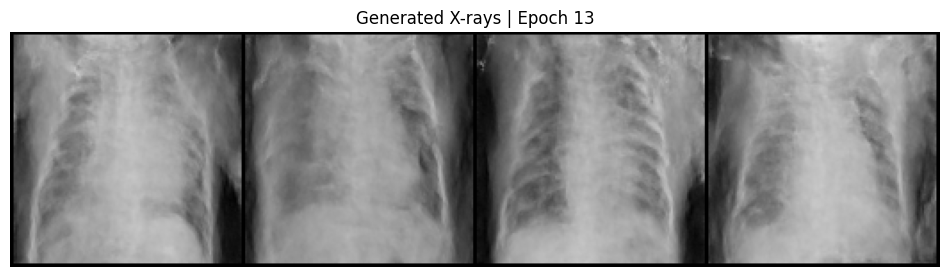

Epoch [14/250]: 100%|██████████| 652/652 [01:46<00:00,  6.13it/s, loss=0.0209] 


Epoch 14 | Avg Loss: 0.0274
   Generating sample images...


Sampling: 500it [00:05, 93.29it/s]


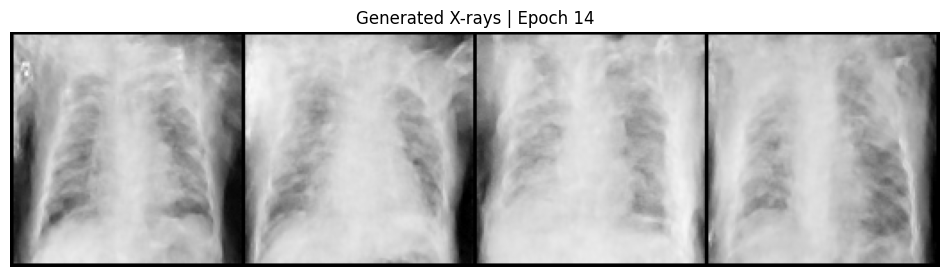

Epoch [15/250]: 100%|██████████| 652/652 [01:47<00:00,  6.09it/s, loss=0.00523]


Epoch 15 | Avg Loss: 0.0259
   Generating sample images...


Sampling: 500it [00:05, 93.27it/s]


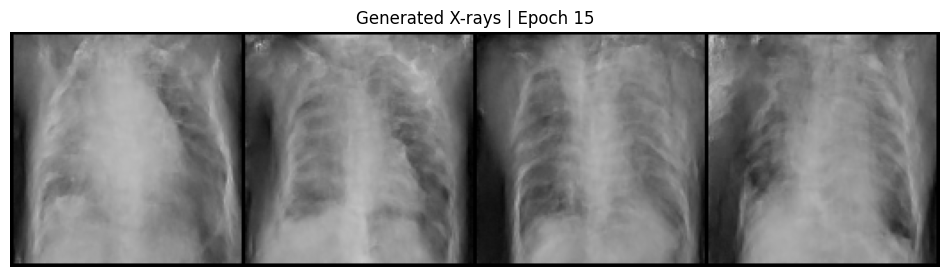

Epoch [16/250]: 100%|██████████| 652/652 [01:46<00:00,  6.12it/s, loss=0.144]  


Epoch 16 | Avg Loss: 0.0261
   Generating sample images...


Sampling: 500it [00:05, 93.23it/s]


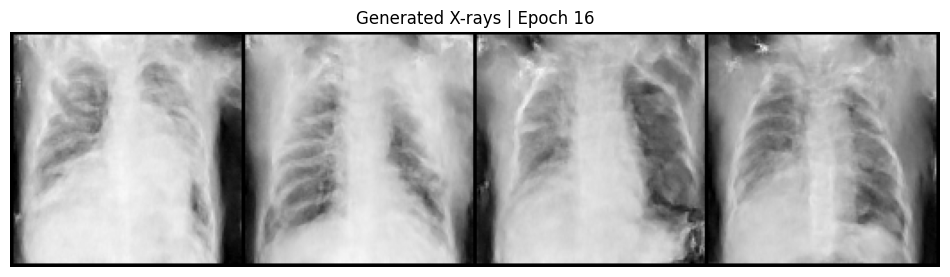

Epoch [17/250]: 100%|██████████| 652/652 [01:46<00:00,  6.14it/s, loss=0.0206] 


Epoch 17 | Avg Loss: 0.0245
   Generating sample images...


Sampling: 500it [00:05, 93.34it/s]


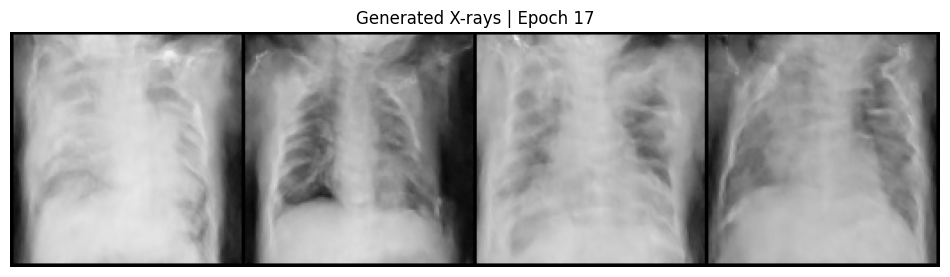

Epoch [18/250]: 100%|██████████| 652/652 [01:46<00:00,  6.14it/s, loss=0.0156] 


Epoch 18 | Avg Loss: 0.0264
   Generating sample images...


Sampling: 500it [00:05, 93.33it/s]


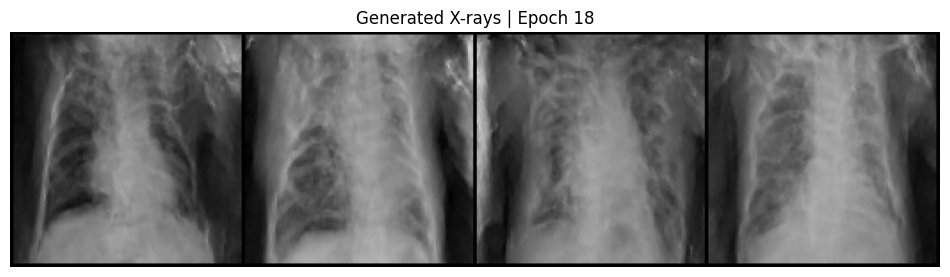

Epoch [19/250]: 100%|██████████| 652/652 [01:47<00:00,  6.06it/s, loss=0.0174] 


Epoch 19 | Avg Loss: 0.0247
   Generating sample images...


Sampling: 500it [00:05, 93.31it/s]


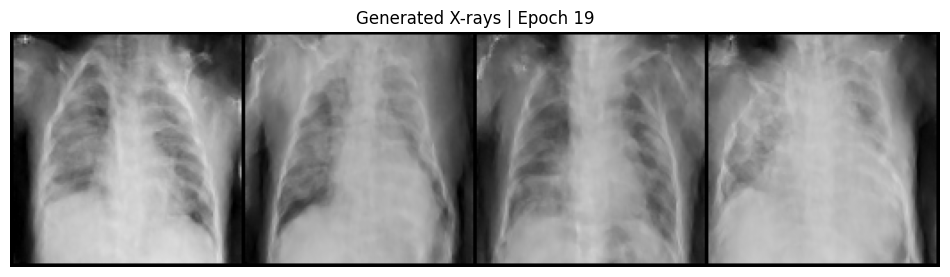

Epoch [20/250]: 100%|██████████| 652/652 [01:47<00:00,  6.08it/s, loss=0.0194] 


Epoch 20 | Avg Loss: 0.0268
   Generating sample images...


Sampling: 500it [00:05, 93.23it/s]


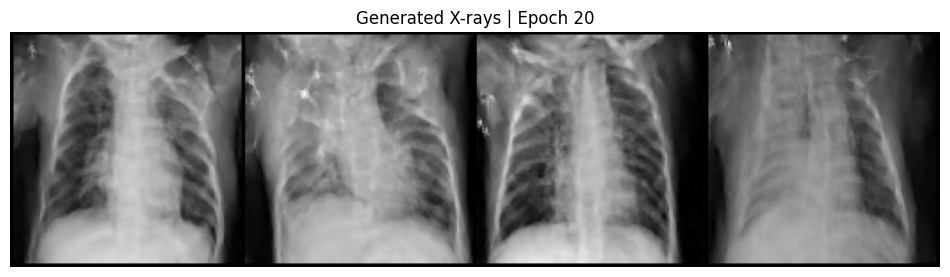

Epoch [21/250]: 100%|██████████| 652/652 [01:47<00:00,  6.05it/s, loss=0.0156] 


Epoch 21 | Avg Loss: 0.0232
   Generating sample images...


Sampling: 500it [00:05, 93.30it/s]


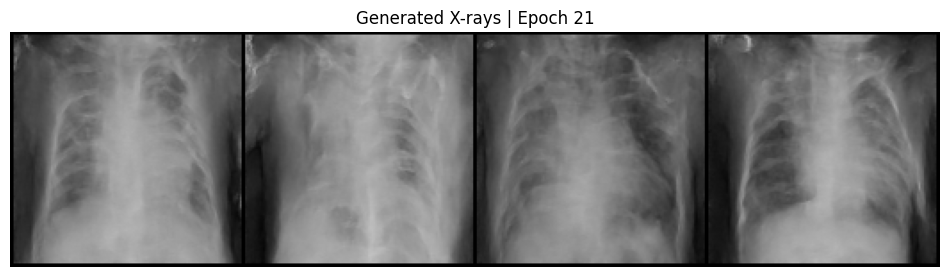

Epoch [22/250]: 100%|██████████| 652/652 [01:47<00:00,  6.04it/s, loss=0.059]  


Epoch 22 | Avg Loss: 0.0255
   Generating sample images...


Sampling: 500it [00:05, 93.20it/s]


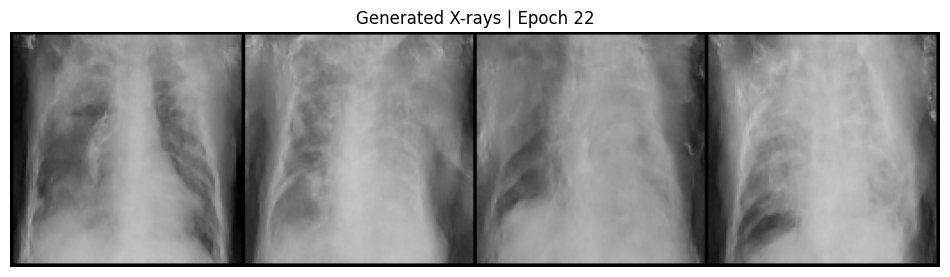

Epoch [23/250]:  10%|█         | 66/652 [00:10<01:32,  6.30it/s, loss=0.0177] 

In [ ]:
# Cell 7: Training Loop with Resume Feature
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(img_channels=1, base_channels=64).to(device)
ddpm = DDPM(model, n_steps=500, device=device, img_size=IMG_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scaler = GradScaler()

n_epochs = 250
save_dir = "/kaggle/working/checkpoints" 
os.makedirs(save_dir, exist_ok=True)
checkpoint_path = os.path.join(save_dir, "latest_checkpoint.pth")
start_epoch = 1

# ==> RESUME LOGIC <==
# Check if a checkpoint exists to resume training
if os.path.exists(checkpoint_path):
    print("✅ Resuming training from the latest checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict']) 
    start_epoch = checkpoint['epoch'] + 1 # Start from the next epoch
    print(f"   Resumed from epoch {start_epoch}")
else:
    print("🏁 Starting training from scratch.")

for epoch in range(start_epoch, n_epochs + 1):
    model.train()
    loop = tqdm(train_dataloader, leave=True) # Set leave=True to see the final bar
    total_loss = 0

    for batch in loop:
        # Unpack batch to get images only
        images, _ = batch
        images = images.to(device)
        
        t = ddpm.sample_timesteps(images.size(0))
        x_t, noise = ddpm.forward_diffusion(images, t)
        
        with autocast():
            pred_noise = model(x_t, t)
            loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        loop.set_description(f"Epoch [{epoch}/{n_epochs}]")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch} | Avg Loss: {avg_loss:.4f}")

    # ==> SAVE CHECKPOINT <==
    # Save model, optimizer, scaler state, and epoch number
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': avg_loss,
    }, checkpoint_path)

    # Generate and save sample images every few epochs
    if epoch % 1 == 0: 
        print("   Generating sample images...")
        model.eval()
        with torch.no_grad():
            samples = ddpm.sample(4)
            samples = (samples.clamp(-1, 1) + 1) / 2 # Denormalize to [0, 1]

            grid = make_grid(samples, nrow=4)
            plt.figure(figsize=(12, 12))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy().squeeze(), cmap="gray")
            plt.title(f"Generated X-rays | Epoch {epoch}")
            plt.axis("off")
            plt.show()

            save_image(samples, os.path.join(save_dir, f"samples_epoch_{epoch}.png"), nrow=4)